In [1]:
!pip install sentence-transformers tqdm torch

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# ARXIV Dataset Curation

In [2]:
from data_loader import ArxivLoader
from text_processing import TextPreprocessor
#arxiv_query = '(cat:cs.CV OR cat:cs.LG OR cat:cs.CL OR cat:cs.AI) AND (ti:medical OR ti:clinical OR ti:health OR ti:ehr OR ti:patient)'
#loader_arxiv= ArxivLoader(query=arxiv_query, limit=11000)
#df_a = loader_arxiv.fetch_data(save_path = 'dataset_arxiv_full_11k.csv')

    cs.CV (Computer Vision)

    cs.LG (Machine Learning)

    cs.CL (Computation and Language / NLP)
    
    cs.AI (Artificial Intelligence)
        
    medical, clinical, health, ehr (Electronic Health Records), or patient.

# IMPORT Libraries and load dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from sentence_transformers import SentenceTransformer, util

/opt/anaconda3/envs/py-38/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [5]:

DATA_PATH = 'dataset_arxiv_full_11k.csv' 

df = pd.read_csv(DATA_PATH, sep = '|' )

In [6]:
print(f"shape: {df.shape}")
cols = ['year', 'abstract', 'title']
df[cols].isna().sum()

shape: (10592, 7)


year        0
abstract    0
title       0
dtype: int64

In [10]:
display(df.head(3))

,id,title,abstract,published,year,categories,doi
0,http://arxiv.org/abs/1512.08051v1,A Multiresolution Clinical Decision Support Sy...,Tissue texture is known to exhibit a heterogen...,2015-12-25 23:21:06+00:00,2015,['cs.CV'],10.1016/j.compmedimag.2014.05.013
1,http://arxiv.org/abs/1512.06492v1,Remote Health Coaching System and Human Motion...,This paper summarizes the recent progress we h...,2015-12-21 04:58:36+00:00,2015,"['cs.CV', 'cs.AI']",NaN
2,http://arxiv.org/abs/1512.03423v1,Predicting proximity with ambient mobile senso...,Modern smart phones are becoming helpful in th...,2015-12-10 03:54:17+00:00,2015,"['cs.CY', 'cs.LG']",10.1109/MICC.2015.7725398


# EDA: Understanding the Dataset


/var/folders/mf/0fcjslb147g8d1jw1mhlspm80000gn/T/ipykernel_90869/1870960956.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='year', data=df, palette='viridis')


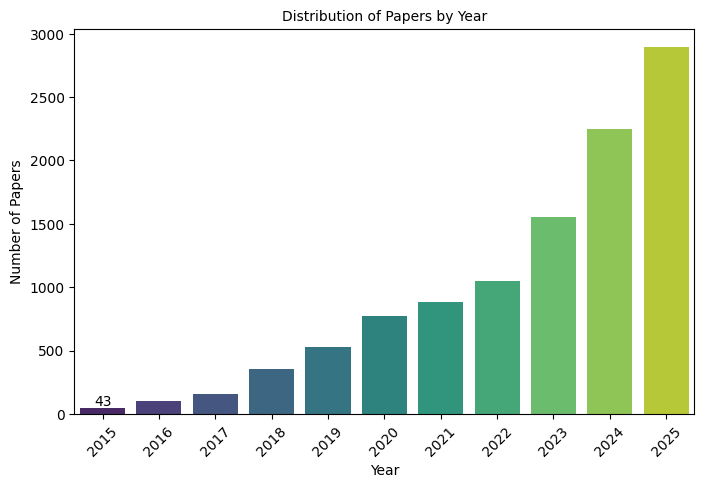

In [12]:
#Papers per Year
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='year', data=df, palette='viridis')
plt.title("Distribution of Papers by Year", fontsize=10)
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.xticks(rotation=45)
plt.bar_label(ax.containers[0])
plt.show()



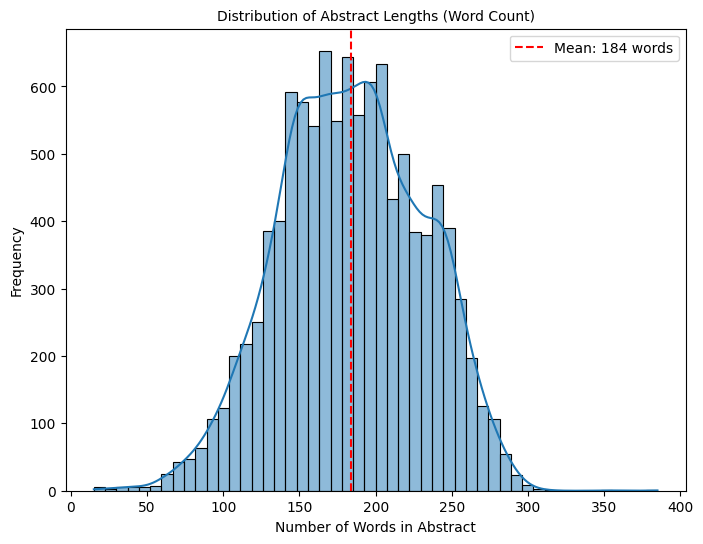

Max word count: 385
95th percentile: 259 words


In [33]:
#PubMedBERT model has a limit of 512 tokens
df['word_count'] = df['abstract'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='#1f77b4')
plt.axvline(df['word_count'].mean(), color='red', linestyle='--', label=f"Mean: {df['word_count'].mean():.0f} words")
plt.title("Distribution of Abstract Lengths (Word Count)", fontsize=10)
plt.xlabel("Number of Words in Abstract")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Max word count: {df['word_count'].max()}")
print(f"95th percentile: {df['word_count'].quantile(0.95):.0f} words")

# APPLY TEXT CLEANING ON ABSTRACT AND TITLE COLUMN, 
    we will merge them later, that is why we apply on both

In [18]:
df["clean_abstract"] = df["abstract"].apply(TextPreprocessor.clean_text)
df["title"] = df["title"].apply(TextPreprocessor.clean_text)

In [20]:
line = df.sample(1).iloc[0]
print(f"original Text: {line.abstract}")

original Text: Background. Dengue outbreaks are a major public health issue, with Brazil reporting 71% of global cases in 2024. Purpose. This study aims to describe the profile of severe dengue patients admitted to Brazilian Intensive Care units (ICUs) (2012-2024), assess trends over time, describe new onset complications while in ICU and determine the risk factors at admission to develop complications during ICU stay. Methods. We performed a prospective study of dengue patients from 253 ICUs across 56 hospitals. We used descriptive statistics to describe the dengue ICU population, logistic regression to identify risk factors for complications during the ICU stay, and a machine learning framework to predict the risk of evolving to complications. Visualisations were generated using ISARIC VERTEX. Results. Of 11,047 admissions, 1,117 admissions (10.1%) evolved to complications, including non-invasive (437 admissions) and invasive ventilation (166), vasopressor (364), blood transfusion (3

In [22]:
print(f"Clean Text: {line.clean_abstract}")

Clean Text: background dengue outbreaks are a major public health issue with brazil reporting 71 of global cases in 2024 purpose this study aims to describe the profile of severe dengue patients admitted to brazilian intensive care units icus 2012 2024 assess trends over time describe new onset complications while in icu and determine the risk factors at admission to develop complications during icu stay methods we performed a prospective study of dengue patients from 253 icus across 56 hospitals we used descriptive statistics to describe the dengue icu population logistic regression to identify risk factors for complications during the icu stay and a machine learning framework to predict the risk of evolving to complications visualisations were generated using isaric vertex results of 11 047 admissions 1 117 admissions 10 1 evolved to complications including non invasive 437 admissions and invasive ventilation 166 vasopressor 364 blood transfusion 353 and renal replacement therapy 103

# Load the Pre-Trained Model, FOUNDED ON HuggingFace, especially trained for medical papers https://huggingface.co/pritamdeka/S-PubMedBert-MS-MARCO

In [29]:
# 4. Load the Pre-Trained Model
from sentence_transformers import SentenceTransformer
import torch

device = "cpu"
MODEL_NAME = 'pritamdeka/S-PubMedBert-MS-MARCO'
print(f"Loading model: {MODEL_NAME}...")

model = SentenceTransformer(MODEL_NAME)
model.to(device)


Loading model: pritamdeka/S-PubMedBert-MS-MARCO...


SentenceTransformer(
  (0): Transformer({'max_seq_length': 350, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

# Merge Title and abstract
    Calculate word counts for the clean text, bcs of limitations of model, token len should be less than 512


In [31]:
df['clean_text'] = df['title'] + " " + df['clean_abstract']
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))

print(f"Mean word count: {df['word_count'].mean()}")
print(f"Max word count: {df['word_count'].max()}")
print(f"Papers > 400 words: {(df['word_count'] > 400).sum()}")

Mean word count: 205.4037009063444
Max word count: 402
Papers > 400 words: 1


# Apply model, by using 32 batch size

In [33]:
print("create vectors for all papers")
embeddings = model.encode(
    df['clean_text'].tolist(), 
    batch_size=32, 
    show_progress_bar=True, 
    convert_to_tensor=True,
    device=device
)


create vectors for all papers


Batches: 100%|████████████████████████████████| 331/331 [13:12<00:00,  2.39s/it]


In [37]:
#Dimension should be 768
embeddings_np = embeddings.cpu().numpy()
print(f"Shape: {embeddings_np.shape}")

Shape: (10592, 768)


In [38]:
# Ensure no vectors are empty/zero
norms = np.linalg.norm(embeddings_np, axis=1)
print(f"Min Vector Length: {norms.min():.4f} (Should be > 0), otherwise inspect or discard papers where vector len 0")

Min Vector Length: 14.7797 (Should be > 0), otherwise inspect or discard papers where vector len 0


#  Aims & Scope Alignment Analysis


In [41]:
from sentence_transformers import util

# Define the "Ground Truth" (The Journal's Mission)
aims_and_scope = """
The Journal publishes high-quality research at the intersection of clinical medicine 
and artificial intelligence. The scope includes the application of machine learning, 
deep learning, computer vision, and natural language processing to medical diagnostics, 
patient outcome prediction, treatment optimization, and healthcare informatics. 
We prioritize studies that demonstrate clinical utility and methodological novelty 
in processing medical images, electronic health records, and genomic data.
"""

In [42]:
#  Encoding 'Aims & Scope, creating vector
scope_embedding = model.encode(aims_and_scope, convert_to_tensor=True)

# Calculate Alignment Score for Every Paper, compute Cosine Similarity between Papers and scope
alignment_scores = util.cos_sim(embeddings, scope_embedding)

df['alignment_score'] = alignment_scores.cpu().numpy()


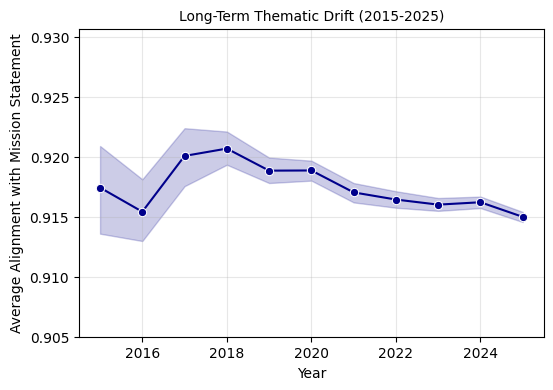

In [43]:
# Thematic Drift 
yearly_alignment = df.groupby('year')['alignment_score'].mean()
    
    # Filter for the relevant period
yearly_alignment = yearly_alignment[yearly_alignment.index >= 2015]
plt.figure(figsize=(6, 4))
plt.ylim(min(yearly_alignment.values) - 0.01, max(yearly_alignment.values) + 0.01)
sns.lineplot(data=df[df['year'] >= 2015], x='year', y='alignment_score', marker='o', color='darkblue')
plt.title("Long-Term Thematic Drift (2015-2025)", fontsize=10)
plt.ylabel("Average Alignment with Mission Statement")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)
plt.show()

In [44]:
# SINCE WE HAVE MOSTLY ALIGNED PAPERS; I DECIDED TO APPLY CLUSTERS to define ground truths

In [45]:
import umap
from sklearn.cluster import KMeans
#Unsupervised Clustering
#Clustering data into 3 semantic topics, (i tried with 4,6,8 but it was going diffetent clusters with same words)
NUM_CLUSTERS = 3
umap_reducer = umap.UMAP(
    n_neighbors=15,      # Size of local neighborhood
    min_dist=0.1,        # How tightly to pack points
    n_components=2,      # Target dimensions (X, Y)
    metric='cosine',     # We use Cosine because these are Semantic Vectors
    random_state=42      # Reproducibility
)

# This takes the complex 768D vectors and flattens them to 2D for plotting
umap_embeddings = umap_reducer.fit_transform(embeddings_np)
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings_np) # Cluster on High-D data, not 2D!

# 3. Store Results in DataFrame
df['x'] = umap_embeddings[:, 0]
df['y'] = umap_embeddings[:, 1]
df['cluster'] = cluster_labels


/opt/anaconda3/envs/py-38/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


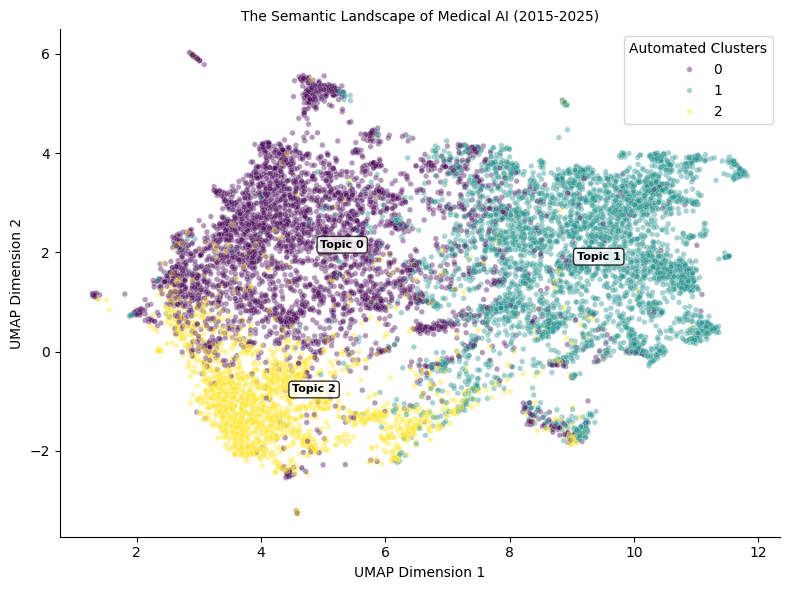

In [46]:
# 7. Visualize the Semantic Landscape
plt.figure(figsize=(8, 6))

# Create the scatter plot
scatter = sns.scatterplot(
    data=df, 
    x='x', 
    y='y', 
    hue='cluster', 
    palette='viridis', 
    s=16,             # Dot size
    alpha=0.4,        # Transparency (helps see density)
    legend='full'
)

# Annotate the Centroids (The "Heart" of each topic)
# We find the center of each cluster in 2D space to label it
for i in range(NUM_CLUSTERS):
    # Find geometric center of the cluster
    cluster_points = df[df['cluster'] == i]
    centroid_x = cluster_points['x'].mean()
    centroid_y = cluster_points['y'].mean()
    
    # Place a big label there
    plt.text(
        centroid_x, centroid_y, 
        f"Topic {i}", 
        fontsize=8, 
        weight='bold', 
        color='black',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round')
    )

plt.title("The Semantic Landscape of Medical AI (2015-2025)", fontsize=10)
plt.xlabel("UMAP Dimension 1", fontsize=10)
plt.ylabel("UMAP Dimension 2", fontsize=10)
plt.legend(title="Automated Clusters", loc='upper right')
plt.grid(False) # Clean look
sns.despine()   # Remove top/right borders
plt.tight_layout()
plt.show()

In [91]:
from Thematic_Drift import ThematicDriftTools
tools = ThematicDriftTools()


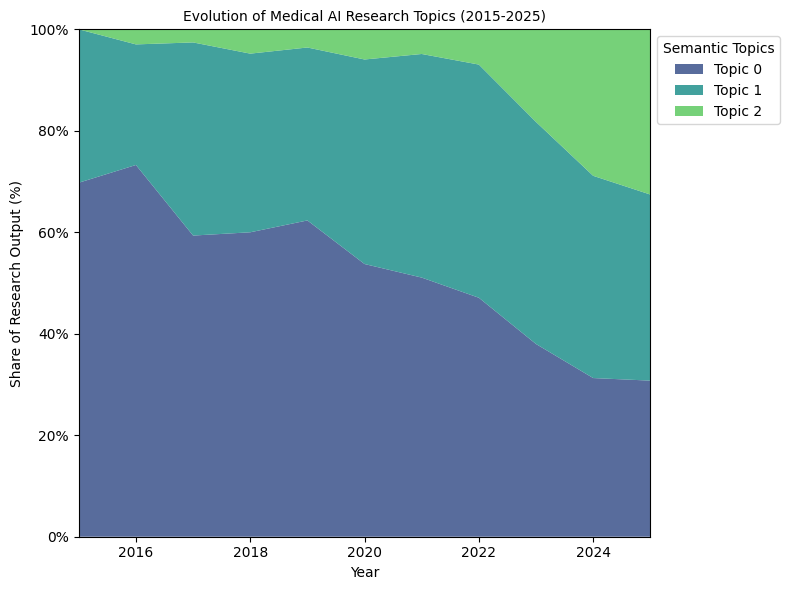

 TOPIC TREND ANALYSIS (2019-2025)
Topic 0: Falling (62.3% -> 30.8%)
Topic 1: Rising (34.1% -> 36.7%)
Topic 2: Rising (3.6% -> 32.6%)


In [93]:
# Run the analysis
NUM_CLUSTERS= 3
evolution_df = tools.plot_topic_evolution(df=df, num_clusters=NUM_CLUSTERS)

# 4. Mathematical "Trend Spotting"
# calculate the slope of the trend to definitively say "Rising" or "Falling"
print(" TOPIC TREND ANALYSIS (2019-2025)")

recent_trend = evolution_df.loc[2019:2026]

for i in range(NUM_CLUSTERS):
    start_share = recent_trend.iloc[0][i]
    end_share = recent_trend.iloc[-1][i]
    change = end_share - start_share
    
    status = "Rising" if change > 2 else "Falling" if change < -2 else "STABLE"
    print(f"Topic {i}: {status} ({start_share:.1f}% -> {end_share:.1f}%)")

In [95]:

keywords = tools.extract_top_keywords(df)

print("CLUSTERS' SEMANTIC SIGNATURES")
for cluster_id, words in keywords.items():
    print(f"Topic {cluster_id}: {words}")

CLUSTERS' SEMANTIC SIGNATURES
Topic 0: data, clinical, health, learning, medical, model, models, patient, based, patients
Topic 1: medical, image, segmentation, learning, data, images, model, models, based, performance
Topic 2: medical, models, clinical, language, llms, large, data, model, health, performance


- Topic 0: Clinical Informatics
    - The Signature: data, clinical, health, patient, based
    
    - This cluster focuses on the "traditional" backbone of the journal. The high frequency of words like "patient" and "health" indicates research involving Electronic Health Records (EHRs), patient outcomes, and clinical data mining.
    
    - "Clinical Informatics" is the standard academic term for using data and information technology to improve healthcare delivery and patient management.

- Topic 1: Computer Vision
    - The Signature: image, segmentation, images, models, performance
    
    - The presence of "image" and "images" is the primary signal here, "Segmentation" is a specific task where AI outlines organs or tumors in scans (MRI, CT, X-ray).
    
    - "Computer Vision" is the broader AI field that enables computers to "see" and interpret visual data. In a medical context, this is almost exclusively related to radiology and pathology imaging.

- Topic 2: Generative AI (LLMs)
    - The Signature: llms, language, large, data, performance
    
    - This is the most distinct modern cluster. The "LLMs" (Large Language Models). The word "large" (as in Large Language Models) confirms we are looking at transformer-based architectures like GPT.
    
    - "Generative AI" describes the technology's ability to create new text or reasoning, while "LLMs" identifies the specific tool being used. This is the "Drift" topic we've been tracking.

In [63]:
#Topic 0: "Clinical Informatics",
#Topic 1: "Computer Vision",
#Topic 2: "Generative AI (LLMs)"

# Generate the Final Summary Report
    by clusters


In [97]:
# Run the Report Generator
final_report = tools.generate_summary_report(keywords, evolution_df)

pd.set_option('display.max_colwidth', 100) # Show full keywords
display(final_report)

Analyzing trends from 2019 to 2025...


,Topic ID,Top Keywords (Semantic Signature),2019,2025,Change,Status
2,2,"medical, models, clinical, language, llms, large, data, model, health, performance",3.6%,32.6%,+29.0%,Rising
1,1,"medical, image, segmentation, learning, data, images, model, models, based, performance",34.1%,36.7%,+2.6%,Rising
0,0,"data, clinical, health, learning, medical, model, models, patient, based, patients",62.3%,30.8%,-31.6%,Falling


In [99]:
# LLM has highest trend, that is why we checked deeply

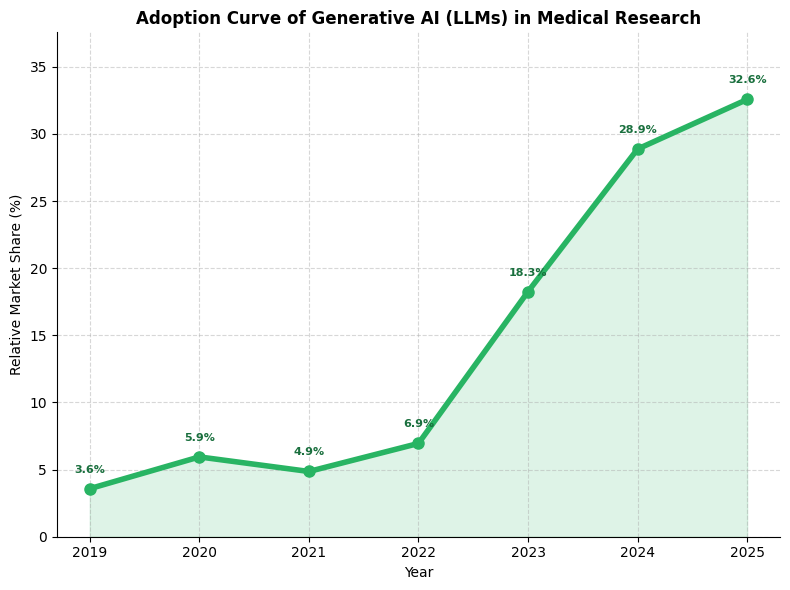

Initial Share (2019): 3.6%
Current Share (2025): 32.6%
Net Growth: +29.0 %


In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
#0: "Clinical Informatics",
#1: "Computer Vision (image)",
#2: "Generative AI (LLMs)"
llm_id = 2
llm_trend = evolution_df[llm_id]

# 2. Filter for the modern era (2019-2025)
llm_modern = llm_trend[llm_trend.index >= 2019]

# 3. Plotting the specialized trend
plt.figure(figsize=(8, 6))

# Line plot with markers
plt.plot(llm_modern.index, llm_modern.values, 
         marker='o', linestyle='-', color='#28B463', linewidth=4, markersize=8, label="Generative AI / LLM Share")

# Fill the area under the curve for visual emphasis on "Growth"
plt.fill_between(llm_modern.index, llm_modern.values, color='#28B463', alpha=0.15)

# Formatting
plt.title("Adoption Curve of Generative AI (LLMs) in Medical Research", fontsize=12, fontweight='bold')
plt.ylabel("Relative Market Share (%)", fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.ylim(0, max(llm_modern.values) + 5)
plt.grid(True, linestyle='--', alpha=0.5)

# Add exact percentage labels on top of each node
for x, y in zip(llm_modern.index, llm_modern.values):
    plt.text(x, y + 1.2, f"{y:.1f}%", ha='center', fontsize=8, fontweight='bold', color='#196F3D')

sns.despine()
plt.tight_layout()
plt.show()

# 4. Statistical Summary for the Final Report
growth_rate = (llm_modern.loc[2025] / llm_modern.loc[2019]) if llm_modern.loc[2019] > 0 else 0
print(f"Initial Share (2019): {llm_modern.loc[2019]:.1f}%")
print(f"Current Share (2025): {llm_modern.loc[2025]:.1f}%")
print(f"Net Growth: {llm_modern.loc[2025] - llm_modern.loc[2019]:+.1f} %")


In [102]:
# Identifying the LLM Papers (Highest Alignment)
core_llm_papers = df[df['cluster'] == 2].sort_values(by='alignment_score', ascending=False).head(5)

print("TOP 5 LLM PAPERS BY ALIGNMENT SCORE")
display(core_llm_papers[['year', 'title', 'alignment_score']])

top_paper_title = core_llm_papers.iloc[0]['title']
top_paper_abstract = core_llm_papers.iloc[0]['abstract']

print(f"Most Aligned LLM Paper")
print(f"TITLE: {top_paper_title}")
print(f"ABSTRACT: {top_paper_abstract}")

TOP 5 LLM PAPERS BY ALIGNMENT SCORE


,year,title,alignment_score
9117,2025,a comprehensive survey of electronic health record modeling from deep learning approaches to lar...,0.952152
6301,2024,clinical insights a comprehensive review of language models in medicine,0.951497
474,2018,lessons from natural language inference in the clinical domain,0.948209
5554,2024,overview of trec 2024 medical video question answering medvidqa track,0.947144
987,2019,surf at mediqa 2019 improving performance of natural language inference in the clinical domain b...,0.946927


Most Aligned LLM Paper
TITLE: a comprehensive survey of electronic health record modeling from deep learning approaches to large language models
ABSTRACT: Artificial intelligence (AI) has demonstrated significant potential in transforming healthcare through the analysis and modeling of electronic health records (EHRs). However, the inherent heterogeneity, temporal irregularity, and domain-specific nature of EHR data present unique challenges that differ fundamentally from those in vision and natural language tasks. This survey offers a comprehensive overview of recent advancements at the intersection of deep learning, large language models (LLMs), and EHR modeling. We introduce a unified taxonomy that spans five key design dimensions: data-centric approaches, neural architecture design, learning-focused strategies, multimodal learning, and LLM-based modeling systems. Within each dimension, we review representative methods addressing data quality enhancement, structural and temporal rep

In [104]:
top_paper_title = core_llm_papers.iloc[1]['title']
top_paper_abstract = core_llm_papers.iloc[1]['abstract']

print(f"TITLE: {top_paper_title}")
print(f"ABSTRACT: {top_paper_abstract}")

TITLE: clinical insights a comprehensive review of language models in medicine
ABSTRACT: This paper explores the advancements and applications of language models in healthcare, focusing on their clinical use cases. It examines the evolution from early encoder-based systems requiring extensive fine-tuning to state-of-the-art large language and multimodal models capable of integrating text and visual data through in-context learning. The analysis emphasizes locally deployable models, which enhance data privacy and operational autonomy, and their applications in tasks such as text generation, classification, information extraction, and conversational systems. The paper also highlights a structured organization of tasks and a tiered ethical approach, providing a valuable resource for researchers and practitioners, while discussing key challenges related to ethics, evaluation, and implementation.


Found 9709 'Core' papers (Score >= 0.9) out of 10592 total.


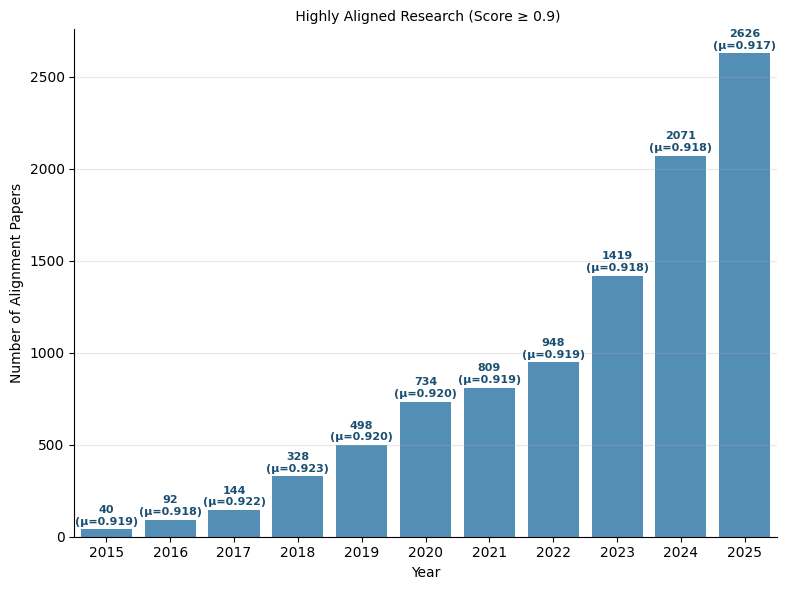

2015 Mean Alignment: 0.9193
2016 Mean Alignment: 0.9177
2017 Mean Alignment: 0.9221
2018 Mean Alignment: 0.9228
2019 Mean Alignment: 0.9205
2020 Mean Alignment: 0.9202
2021 Mean Alignment: 0.9192
2022 Mean Alignment: 0.9188
2023 Mean Alignment: 0.9182
2024 Mean Alignment: 0.9180
2025 Mean Alignment: 0.9171


In [108]:
# Growth Analysis (Alignment > 0.90)
import matplotlib.pyplot as plt
import seaborn as sns

# We select only papers that are highly aligned with the aim&scope
core_threshold = 0.90
core_df = df[df['alignment_score'] >= core_threshold]

print(f"Found {len(core_df)} 'Core' papers (Score >= {core_threshold}) out of {len(df)} total.")

#  Get Count AND Mean Score per Year
yearly_stats = core_df.groupby('year')['alignment_score'].agg(['count', 'mean']).sort_index()

yearly_stats = yearly_stats[yearly_stats.index >= 2015]

plt.figure(figsize=(8, 6))

# Bar Chart
ax = sns.barplot(
    x=yearly_stats.index, 
    y=yearly_stats['count'], 
    color='#2E86C1', 
    alpha=0.9
)

plt.title(f" Highly Aligned Research (Score ≥ {core_threshold})", fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.ylabel("Number of Alignment Papers", fontsize=10)
plt.grid(axis='y', alpha=0.3)

for i, year in enumerate(yearly_stats.index):
    count = yearly_stats.loc[year, 'count']
    mean_val = yearly_stats.loc[year, 'mean']
    
    label = f"{int(count)}\n(µ={mean_val:.3f})"
    
    ax.text(i, count + 15, label, ha='center', va='bottom', fontsize=8, fontweight='bold', color='#1B4F72')

sns.despine()
plt.tight_layout()
plt.show()


for year in range(2015, 2026):
    mean_val = yearly_stats.loc[year, 'mean']
    print(f"{year} Mean Alignment: {mean_val:.4f}")

In [109]:
# OUTLIER DETECTION ---Identify the "Least Aligned" papers 
outliers = df.sort_values(by='alignment_score', ascending=True).head(3)
display(outliers[['year', 'title', 'alignment_score', 'clean_text']])

,year,title,alignment_score,clean_text
3854,2022,a survey on patients privacy protection with stganography and visual encryption,0.867467,a survey on patients privacy protection with stganography and visual encryption in this survey t...
1583,2020,challenging common bolus advisor for self monitoring type i diabetes patients using reinforcemen...,0.871563,challenging common bolus advisor for self monitoring type i diabetes patients using reinforcemen...
4531,2023,dynamic strategy chain dynamic zero shot cot for long mental health support generation,0.873398,dynamic strategy chain dynamic zero shot cot for long mental health support generation long coun...


In [110]:
outliers.clean_text.iloc[2]

'dynamic strategy chain dynamic zero shot cot for long mental health support generation long counseling text generation for mental health support ltgm an innovative and challenging task aims to provide help seekers with mental health support through a comprehensive and more acceptable response the combination of chain of thought cot prompting and large language models llms is employed and get the sota performance on various nlp tasks especially on text generation tasks zero shot cot prompting is one of the most common methods in cot prompting however in the ltgm task zero shot cot prompting can not simulate a counselor or provide personalized strategies without effective mental health counseling strategy prompts to tackle this challenge we propose a zero shot dynamic strategy chain dsc prompting method firstly we utilize gpt2 to learn the responses written by mental health counselors and dynamically generate mental health counseling strategies tailored to the help seekers needs secondl

Generating thematic snapshots for the modern era...


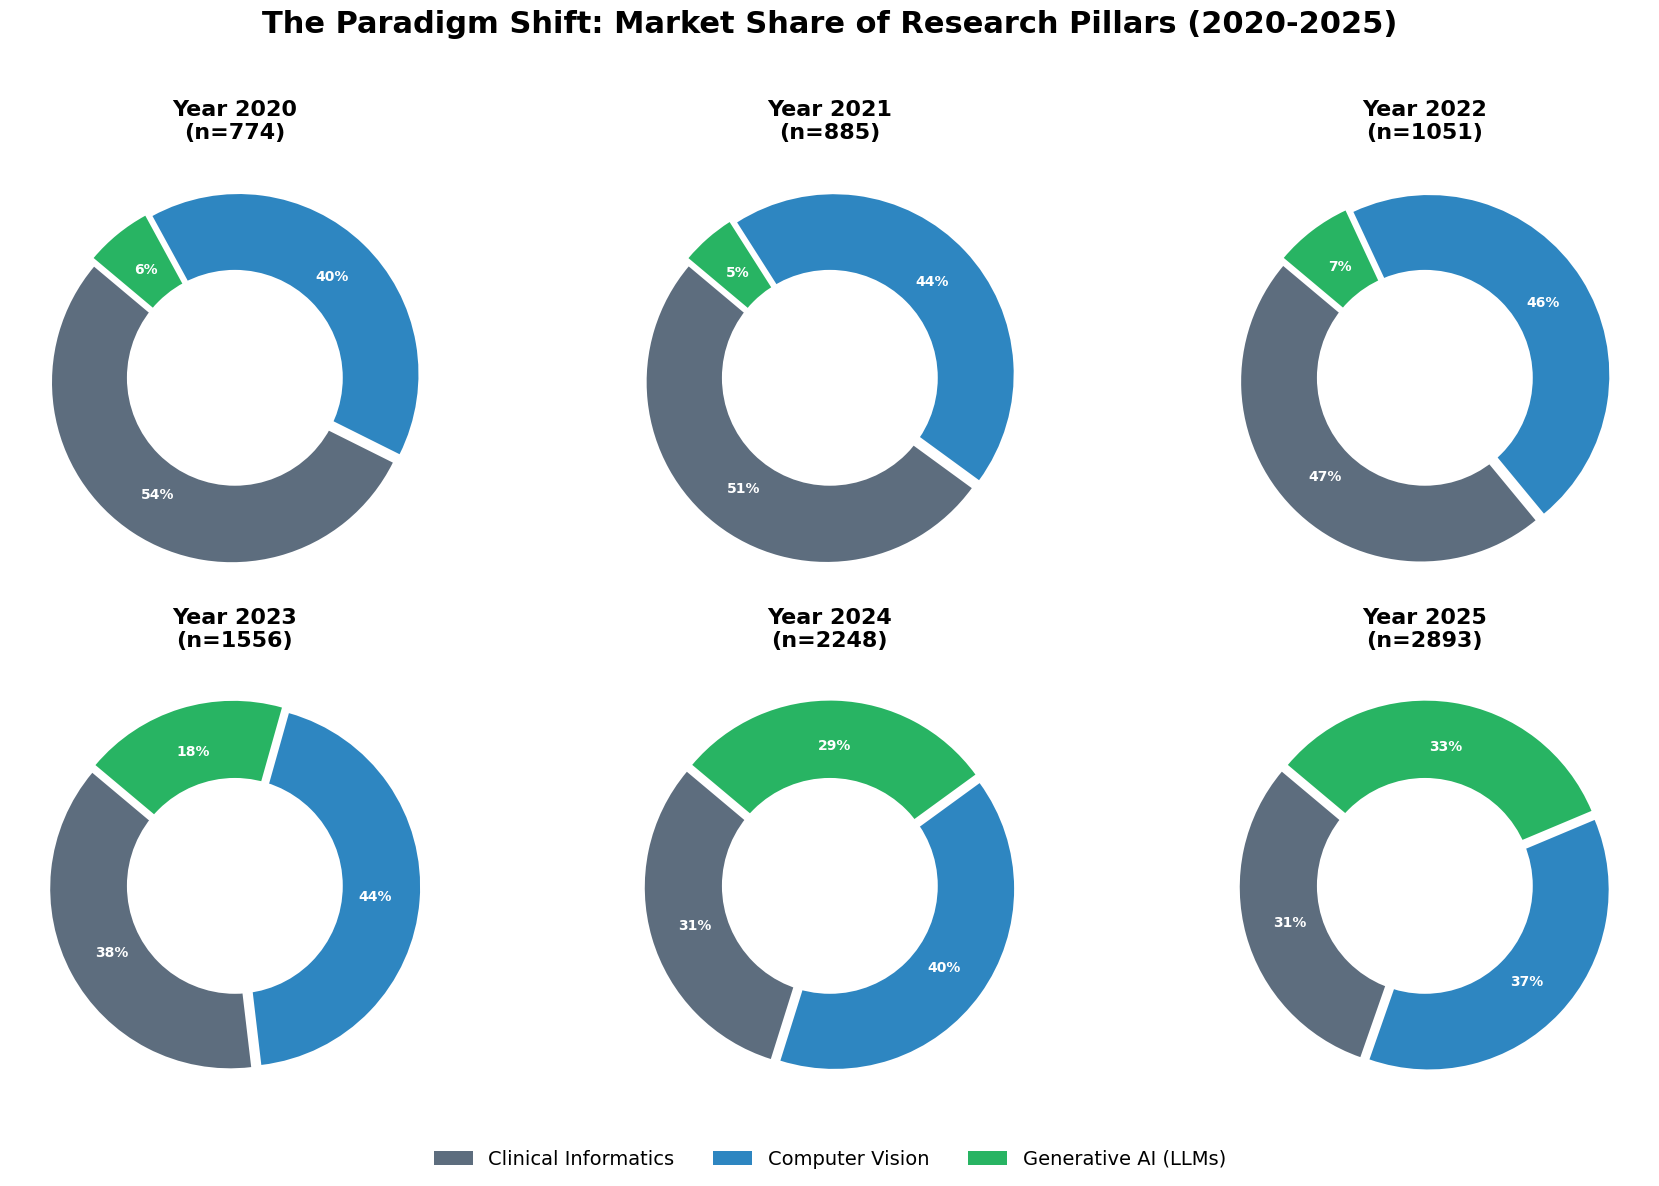

In [115]:
# 19. Comparative Snapshot Grid: 2020-2025 Evolution
import matplotlib.pyplot as plt

# 1. Configuration
years = [2020, 2021, 2022, 2023, 2024, 2025]
topic_names = {
    0: "Clinical Informatics",
    1: "Computer Vision",
    2: "Generative AI (LLMs)"
}
colors = ['#5D6D7E', '#2E86C1', '#28B463'] # Consistent Gray, Blue, Green

# 2. Setup the Grid (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten() # Flatten to 1D array for easy looping

print("Generating thematic snapshots for the modern era...")

for i, year in enumerate(years):
    ax = axes[i]
    
    # Filter data for the specific year
    year_data = df[df['year'] == year]
    
    if len(year_data) == 0:
        ax.set_title(f"Year {year}: No Data", fontsize=14)
        continue
        
    # Count clusters and ensure 0, 1, 2 are all represented (even if 0)
    counts = year_data['cluster'].value_counts().reindex([0, 1, 2], fill_value=0)
    labels = [topic_names[j] for j in counts.index]
    sizes = counts.values
    
    # Create the donut slice
    wedges, texts, autotexts = ax.pie(
        sizes, 
        autopct='%1.0f%%', # Rounded to nearest whole number for small figs
        startangle=140, 
        colors=colors,
        pctdistance=0.75,
        explode=[0.03, 0.03, 0.03],
        textprops={'fontsize': 10, 'fontweight': 'bold', 'color': 'white'}
    )
    
    # Add the "Donut" hole
    centre_circle = plt.Circle((0,0), 0.60, fc='white')
    ax.add_artist(centre_circle)
    
    # Label each subplot
    ax.set_title(f"Year {year}\n(n={len(year_data)})", fontsize=16, fontweight='bold', pad=10)
    
fig.legend(wedges, labels, loc='lower center', ncol=3, fontsize=14, frameon=False)

plt.suptitle("The Paradigm Shift: Market Share of Research Pillars (2020-2025)", fontsize=22, y=0.98, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust for legend and suptitle
plt.show()